In [4]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical


# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import glob
import numpy as np
from tqdm import tqdm

In [5]:
# upload the data
classes = pd.read_csv('UrbanSound8K.csv')

FileNotFoundError: [Errno 2] File UrbanSound8K.csv does not exist: 'UrbanSound8K.csv'

In [ ]:
classes[["class", "classID"]]

In [ ]:
classes_code = dict()
for Class, classID in zip(classes["class"], classes["classID"]):
    classes_code[classID] = Class
    pass
pass
# A dictionnary doesn't accept double values
print(classes_code)

In [ ]:
# let's check how many folders we have
glob.glob('urban_dataset//**')

In [ ]:
# Building our dataset
dataset = list()
for folder in glob.glob('urban_dataset//**'):
    list_sounds_path = glob.glob(folder+"//**")
    for elm in list_sounds_path:
        label = elm.split(".wav")[0][-5]
        if label == '-':
            label = elm.split(".wav")[0][-6]
        dataset.append({"file_name" : elm,
                       "label" : label})
        pass
    pass
pass
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state = 42)

In [ ]:
dataset.head()

In [ ]:
dataset['label'].value_counts().plot(kind = "bar", title="Dataset distribution")
plt.show()

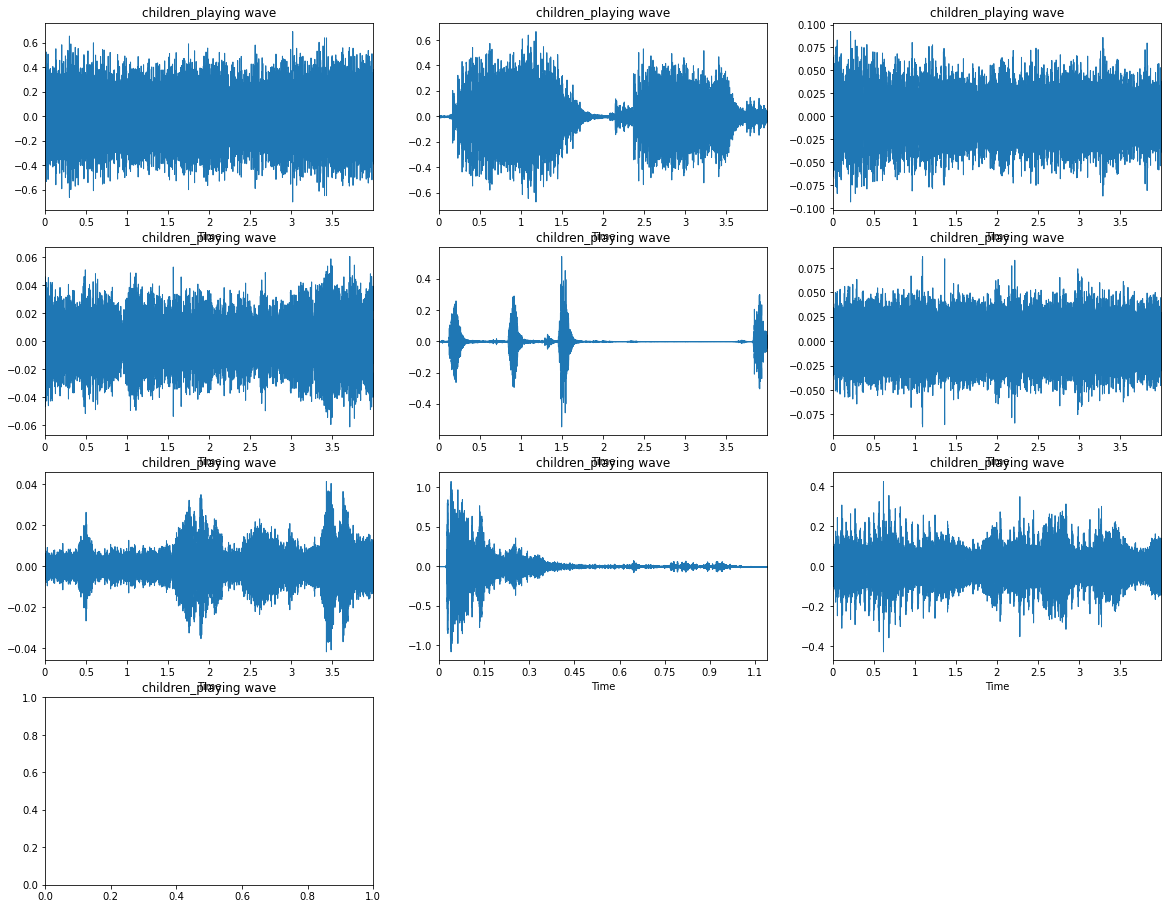

In [101]:
plt.figure(figsize=(20,20))
idx = 0
for elm in dataset['label'].unique():
    idx += 1
    wave, sampling_rate = librosa.load(dataset[dataset.label == elm].file_name.iloc[0], duration = 5)
    librosa.display.waveplot(wave, sr = sampling_rate)
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % classes_code[int(label)])
plt.show()